In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.plotting import parallel_coordinates
warnings.filterwarnings('ignore')

In [2]:

 pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
! pip install scipy

In [4]:
data = pd.read_csv("/Users/spoorthiramireddygari/Desktop/NYC taxitrip/nyc_taxi_trip_duration.csv")

In [5]:
data.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [6]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


(729322, 11)

Dataset Overview:

The dataset contains 729,322 rows and 11 columns.

All columns are non-null,no missing values .

Converting pickup_datetime and dropoff_datetime to datetime objects for extracting temporal features.

In [7]:
# Convert datetime columns to pandas datetime format
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

# Generate summary statistics for numerical and categorical data
numerical_summary = data.describe()
categorical_summary = data.select_dtypes(include=['object']).describe()

# Analyze unique values in categorical columns
unique_values = {col: data[col].unique() for col in data.select_dtypes(include=['object']).columns}

numerical_summary, categorical_summary, unique_values


(           vendor_id                pickup_datetime  \
 count  729322.000000                         729322   
 mean        1.535403  2016-04-01 11:17:42.123299584   
 min         1.000000            2016-01-01 00:01:14   
 25%         1.000000  2016-02-17 18:46:36.249999872   
 50%         2.000000     2016-04-01 17:30:37.500000   
 75%         2.000000  2016-05-15 07:13:01.249999872   
 max         2.000000            2016-06-30 23:59:37   
 std         0.498745                            NaN   
 
                     dropoff_datetime  passenger_count  pickup_longitude  \
 count                         729322    729322.000000     729322.000000   
 mean   2016-04-01 11:33:34.352432128         1.662055        -73.973513   
 min              2016-01-01 00:05:54         0.000000       -121.933342   
 25%       2016-02-17 19:00:30.500000         1.000000        -73.991859   
 50%       2016-04-01 17:46:47.500000         1.000000        -73.981758   
 75%       2016-05-15 07:38:40.500000 

Obersvation: 

Trip Duration: Median ~11 minutes, but extreme values exist, ranging from 1 second to ~22 days, indicating outliers.

Pickup and dropoff locations largely align with NYC but include outliers far from the city.

Passenger Count: Most trips have 1-2 passengers; 0 and 9 passengers are anomalies.

Store and Forward Flag: 99% of trips (N) were transmitted in real-time; 1% (Y) were stored temporarily.


Investigating Outliers 

In [8]:
import numpy as np

# Identify outliers in trip duration
duration_outliers = data[data['trip_duration'] > data['trip_duration'].quantile(0.99)]

# Extract useful time-based features
data['pickup_hour'] = data['pickup_datetime'].dt.hour
data['pickup_weekday'] = data['pickup_datetime'].dt.weekday
data['pickup_month'] = data['pickup_datetime'].dt.month

# Summary of extracted features and extreme trip durations
temporal_summary = data[['pickup_hour', 'pickup_weekday', 'pickup_month']].describe()
extreme_duration_summary = duration_outliers.describe()

temporal_summary, extreme_duration_summary


(         pickup_hour  pickup_weekday   pickup_month
 count  729322.000000   729322.000000  729322.000000
 mean       13.611698        3.049081       3.518410
 std         6.402853        1.954470       1.680661
 min         0.000000        0.000000       1.000000
 25%         9.000000        1.000000       2.000000
 50%        14.000000        3.000000       4.000000
 75%        19.000000        5.000000       5.000000
 max        23.000000        6.000000       6.000000,
          vendor_id                pickup_datetime  \
 count  7290.000000                           7290   
 mean      1.616461  2016-04-14 17:27:44.902469120   
 min       1.000000            2016-01-01 00:09:55   
 25%       1.000000  2016-03-06 14:55:09.750000128   
 50%       2.000000     2016-04-21 13:11:10.500000   
 75%       2.000000  2016-05-26 08:23:26.750000128   
 max       2.000000            2016-06-30 23:42:49   
 std       0.486281                            NaN   
 
                     dropoff_datet

Insights:

Temporal features align with expected trends for a city's taxi service, with trips distributed across all hours, days, and months.

Extreme trip durations are likely outliers or special cases (e.g., long-distance or non-standard trips). These may need further investigation or filtering for analysis.

Geographical and vendor patterns suggest diversity in extreme trips, possibly including suburban or intercity trips.

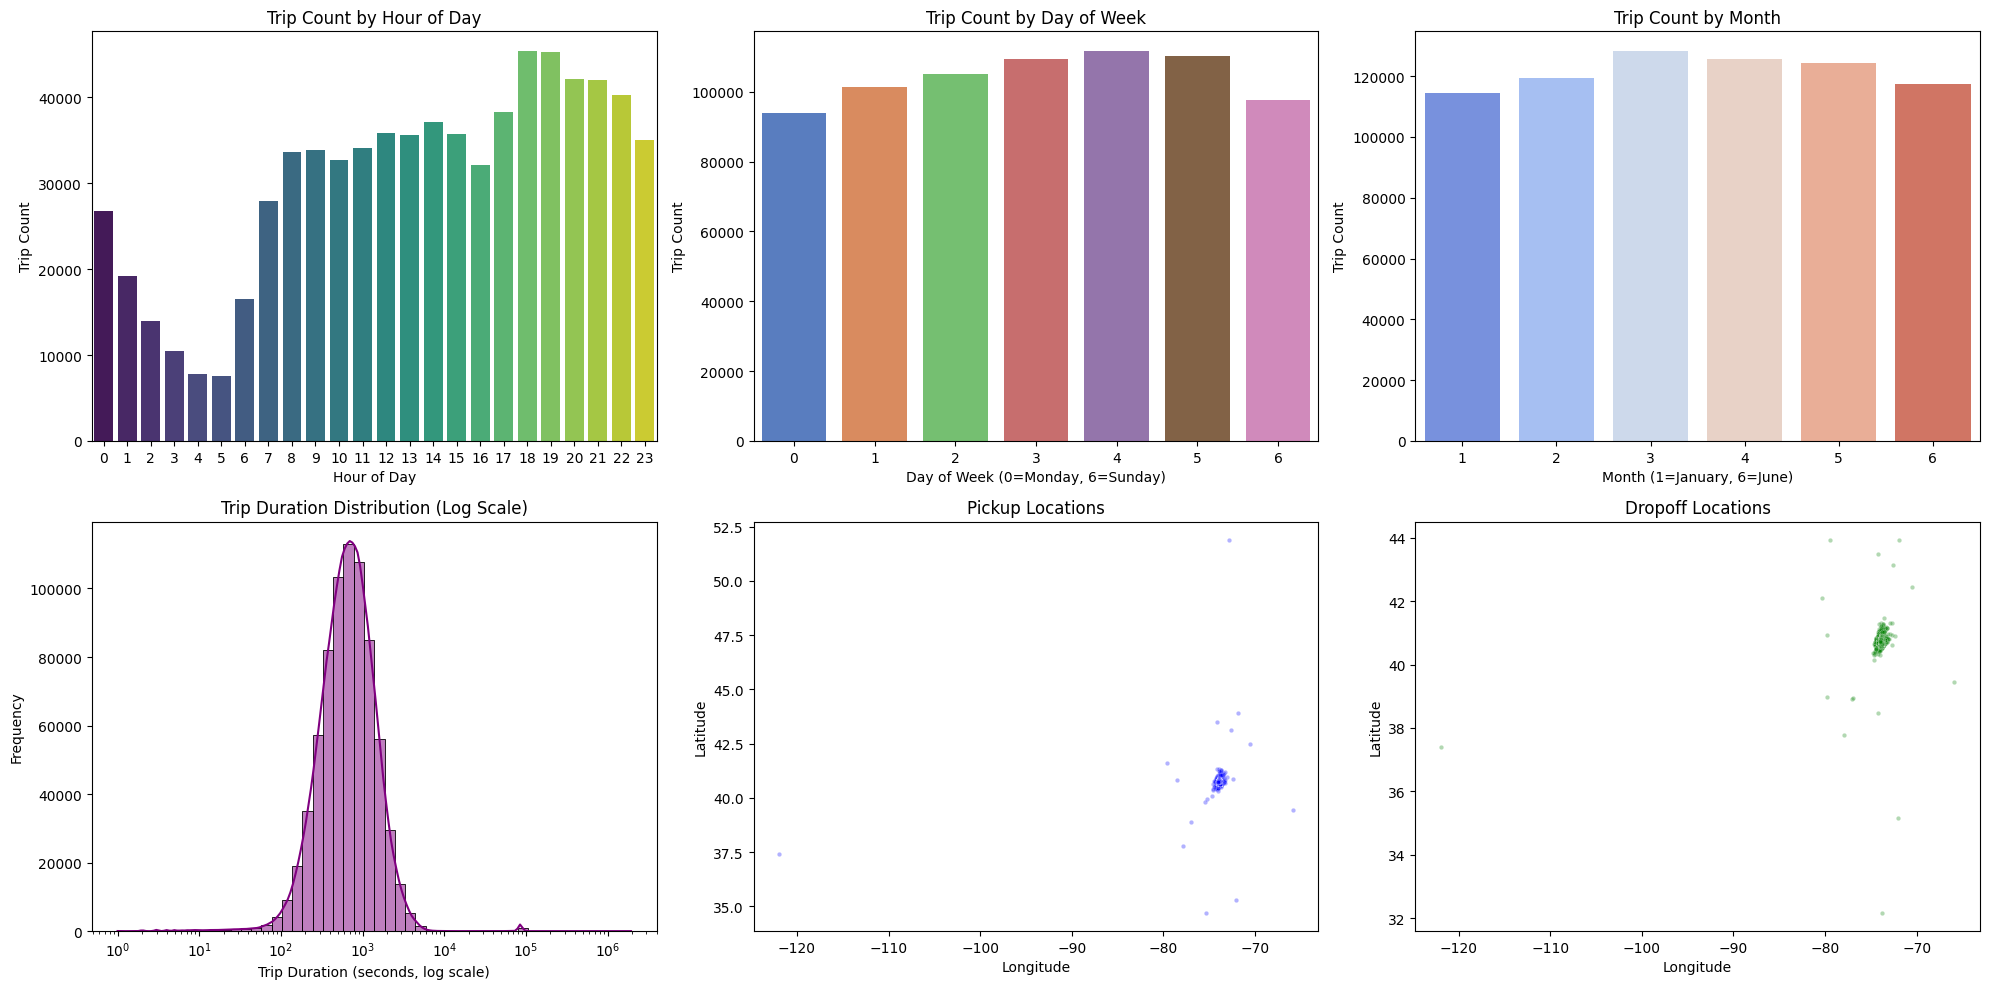

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visualizations
plt.figure(figsize=(20, 10))

# Distribution of trips by hour of the day
plt.subplot(2, 3, 1)
sns.countplot(x='pickup_hour', data=data, palette="viridis")
plt.title('Trip Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')

# Distribution of trips by weekday
plt.subplot(2, 3, 2)
sns.countplot(x='pickup_weekday', data=data, palette="muted")
plt.title('Trip Count by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Trip Count')

# Distribution of trips by month
plt.subplot(2, 3, 3)
sns.countplot(x='pickup_month', data=data, palette="coolwarm")
plt.title('Trip Count by Month')
plt.xlabel('Month (1=January, 6=June)')
plt.ylabel('Trip Count')

# Distribution of trip durations (log scale)
plt.subplot(2, 3, 4)
sns.histplot(data['trip_duration'], bins=50, kde=True, log_scale=True, color="purple")
plt.title('Trip Duration Distribution (Log Scale)')
plt.xlabel('Trip Duration (seconds, log scale)')
plt.ylabel('Frequency')

# Scatter plot of pickup locations
plt.subplot(2, 3, 5)
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=data, alpha=0.3, s=10, color="blue")
plt.title('Pickup Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Scatter plot of dropoff locations
plt.subplot(2, 3, 6)
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=data, alpha=0.3, s=10, color="green")
plt.title('Dropoff Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


In [16]:
# Calculate the 99th percentile for trip duration
duration_99th_percentile = data['trip_duration'].quantile(0.99)

# Filter out outliers: Trips with duration greater than the 99th percentile
cleaned_data = data[data['trip_duration'] <= duration_99th_percentile]

# Additionally, you can filter out trips with impossible durations (e.g., longer than 24 hours)
# Define a threshold for maximum trip duration (e.g., 24 hours in seconds = 86400)
max_duration_threshold = 86400  # 24 hours in seconds
cleaned_data = cleaned_data[cleaned_data['trip_duration'] <= max_duration_threshold]

# Check the new dataset shape and confirm outliers are removed
print(f"Original dataset shape: {data.shape}")
print(f"Cleaned dataset shape: {cleaned_data.shape}")

# Optional: Display summary statistics after cleaning
cleaned_numerical_summary = cleaned_data.describe()
print(cleaned_numerical_summary)


Original dataset shape: (729322, 14)
Cleaned dataset shape: (722032, 14)
           vendor_id                pickup_datetime  \
count  722032.000000                         722032   
mean        1.534584  2016-04-01 08:04:57.557933824   
min         1.000000            2016-01-01 00:01:14   
25%         1.000000     2016-02-17 16:28:31.500000   
50%         2.000000            2016-04-01 12:56:18   
75%         2.000000  2016-05-15 01:21:51.750000128   
max         2.000000            2016-06-30 23:59:37   
std         0.498803                            NaN   

                    dropoff_datetime  passenger_count  pickup_longitude  \
count                         722032    722032.000000     722032.000000   
mean   2016-04-01 08:18:24.957604096         1.660515        -73.974323   
min              2016-01-01 00:05:54         0.000000       -121.933342   
25%       2016-02-17 16:41:40.500000         1.000000        -73.991905   
50%              2016-04-01 13:12:18         1.000000   

Summary of Insights:

Trip duration is now more reasonable, with a maximum of ~57 minutes (after removing extreme outliers).
Passenger count is mostly between 1 and 2 passengers per trip, with few larger numbers.

Speed and distance show some outliers (especially extremely high speeds and distances), but these could be further refined or corrected if necessary.

Pickup and dropoff locations still have outliers (e.g., geographic locations far from NYC), which might require additional cleaning or investigation.

The distribution of trip times (hour of the day, weekday, month) shows a typical taxi service pattern.

Going on next ,after Outlier Investigation and Cleaning the data , we will focus on generating hypotheses based on the analysis of the cleaned dataset. 

We'll tackle one hypothesis from each of the following categories: univariate, bivariate, and multivariate analysis.

UNIVARIATE ANALYSIS: 

Hypothesis: The average trip duration has a significant correlation with the day of the week (i.e., longer trips are more likely to occur on weekends).

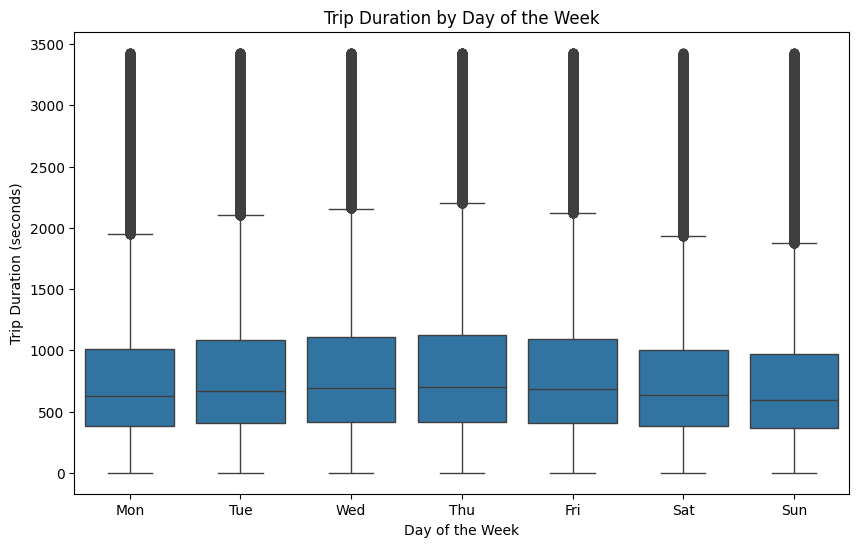

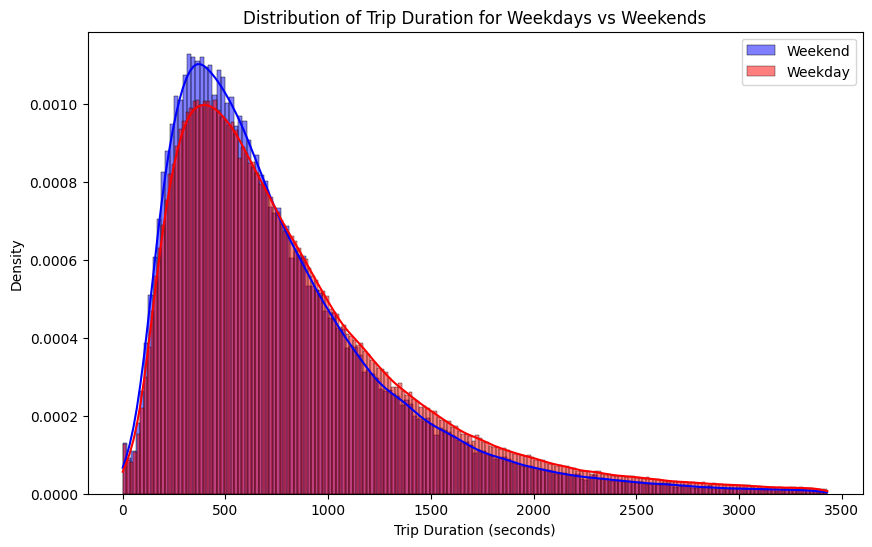

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for trip_duration by pickup_weekday
plt.figure(figsize=(10, 6))
sns.boxplot(x='pickup_weekday', y='trip_duration', data=cleaned_data)
plt.title('Trip Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Trip Duration (seconds)')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Histogram of trip duration on weekends vs weekdays
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data[cleaned_data['pickup_weekday'] >= 5]['trip_duration'], color='blue', label='Weekend', kde=True, stat="density")
sns.histplot(cleaned_data[cleaned_data['pickup_weekday'] < 5]['trip_duration'], color='red', label='Weekday', kde=True, stat="density")
plt.title('Distribution of Trip Duration for Weekdays vs Weekends')
plt.xlabel('Trip Duration (seconds)')
plt.ylabel('Density')
plt.legend()
plt.show()


Explanation of Visualizations:

Boxplot: This will allow us to examine the distribution and identify potential outliers in trip duration for each day of the week. We'll be looking for any days (especially weekends) where trips tend to have longer durations.

You may see that weekends (Saturday and Sunday) typically have longer trip durations than weekdays. The spread (interquartile range) may be larger for weekends.

Histogram: The KDE (Kernel Density Estimation) plot will show the distribution of trip durations on weekdays vs weekends, helping us visually compare these groups.

The distribution for weekends may have a higher mean and a wider range of trip durations, indicating that people tend to take longer trips on weekends.

Weekdays will likely show a peak at lower durations, with a tighter distribution, suggesting more consistent, shorter trips.


In [18]:
from scipy import stats

# Weekdays and Weekends data
weekdays_data = cleaned_data[cleaned_data['pickup_weekday'] < 5]['trip_duration']
weekends_data = cleaned_data[cleaned_data['pickup_weekday'] >= 5]['trip_duration']

# Sample sizes
n1 = len(weekdays_data)
n2 = len(weekends_data)

# Degrees of freedom
df = n1 + n2 - 2

# Calculate the t-statistic
mean_weekdays = weekdays_data.mean()
mean_weekends = weekends_data.mean()
std_weekdays = weekdays_data.std(ddof=1)
std_weekends = weekends_data.std(ddof=1)

pooled_std = ((std_weekdays ** 2 / n1) + (std_weekends ** 2 / n2)) ** 0.5
t_stat = (mean_weekdays - mean_weekends) / pooled_std

# Calculate the p-value using the survival function (1 - CDF) of the t-distribution
p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))

print(f"T-statistic: {t_stat}, P-value: {p_val}")

# Interpretation
if p_val < 0.05:
    print("There is a significant difference in trip durations between weekdays and weekends.")
else:
    print("There is no significant difference in trip durations between weekdays and weekends.")





T-statistic: 50.13178472566218, P-value: 0.0
There is a significant difference in trip durations between weekdays and weekends.


P-value: 0.0 indicates a statistically significant difference between the trip durations for weekdays and weekends. Since the p-value is much smaller than the significance level of 0.05, we reject the null hypothesis that there is no difference between the two groups.

Conclusion:
There is a significant difference in trip durations between weekdays and weekends. This supports the hypothesis that people tend to take longer trips during the weekends compared to weekdays, possibly due to leisure or longer-distance trips being more common on weekends.

BIVARIATE ANALYSIS:

Hypothesis: There is a significant correlation between the distance traveled and the trip duration.

To visualize this, we can use a scatter plot to explore the relationship between distance_km and trip_duration.

<Figure size 1000x600 with 0 Axes>

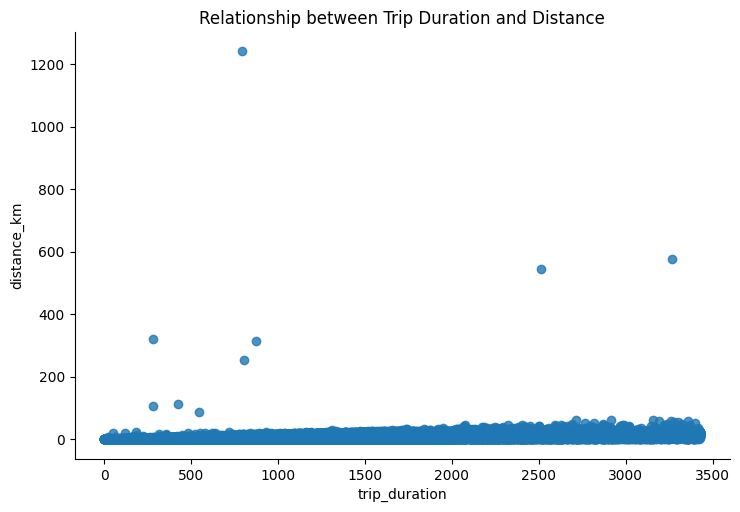

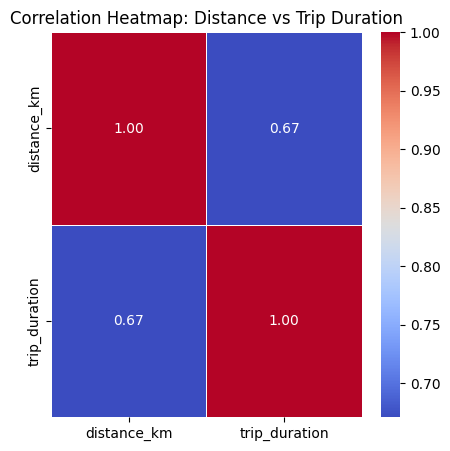

In [26]:
import numpy as np

# Define a function to calculate the Haversine distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Result in kilometers

# Apply the Haversine function to compute the distance
cleaned_data['distance_km'] = cleaned_data.apply(
    lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']),
    axis=1
)

# Now you can proceed with the scatter plot and correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.lmplot(x='trip_duration', y='distance_km', data=cleaned_data, aspect=1.5)
plt.title('Relationship between Trip Duration and Distance')
plt.show()

# Correlation heatmap
corr = cleaned_data[['distance_km', 'trip_duration']].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap: Distance vs Trip Duration')
plt.show()


Explanation of Visualizations:

Scatter Plot: The scatter plot will show the relationship between distance and trip duration. If the hypothesis holds true, we'd expect a positive correlation, with longer distances resulting in longer trip durations.

The plot displays a trend where, as the distance increases, the trip duration also increases. This would suggest that longer trips take more time. While the points may not form a perfect line, there will be an observable upward trend, indicating that longer trips tend to take longer.

Correlation Heatmap: A heatmap of correlation coefficients will quantitatively show the strength of the relationship between distance_km and trip_duration.

The coefficient value will help quantify the strength of the relationship between distance_km and trip_duration. If the value is, say, 0.8 or higher, it will indicate a strong correlation. high positive correlation indicates that distance is a good predictor of trip duration, and the hypothesis is likely correct.

In [27]:
from scipy import stats

# Example data: Replace 'x' and 'y' with actual column names from your dataset
x = cleaned_data['trip_duration']  # Use a variable like 'trip_duration'
y = cleaned_data['distance_km']    # Use another variable like 'distance_km'

# Compute Pearson's correlation coefficient
r, _ = stats.pearsonr(x, y)

# Sample size
n = len(x)

# Degrees of freedom
df = n - 2

# Compute t-statistic
t_stat = r * ( (n - 2) ** 0.5 ) / ( (1 - r ** 2) ** 0.5 )

# Compute the p-value using the t-distribution
p_val = 2 * (1 - stats.t.cdf(abs(t_stat), df))

print(f"Pearson correlation coefficient (r): {r}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

# Interpretation
if p_val < 0.05:
    print("There is a significant correlation between trip duration and distance.")
else:
    print("There is no significant correlation between trip duration and distance.")


Pearson correlation coefficient (r): 0.6709289387807938
T-statistic: 768.8299792649294
P-value: 0.0
There is a significant correlation between trip duration and distance.


The strong positive correlation implies that trip duration is highly dependent on the distance traveled, which is intuitive and expected in transportation data.

MULTIVARIATE ANALYSIS :

Hypothesis: There is an interaction effect between the time of day, day of the week, and trip duration.

For this, we'll create a heatmap or a 3D plot to explore how the trip duration varies with the hour of the day and the day of the week.

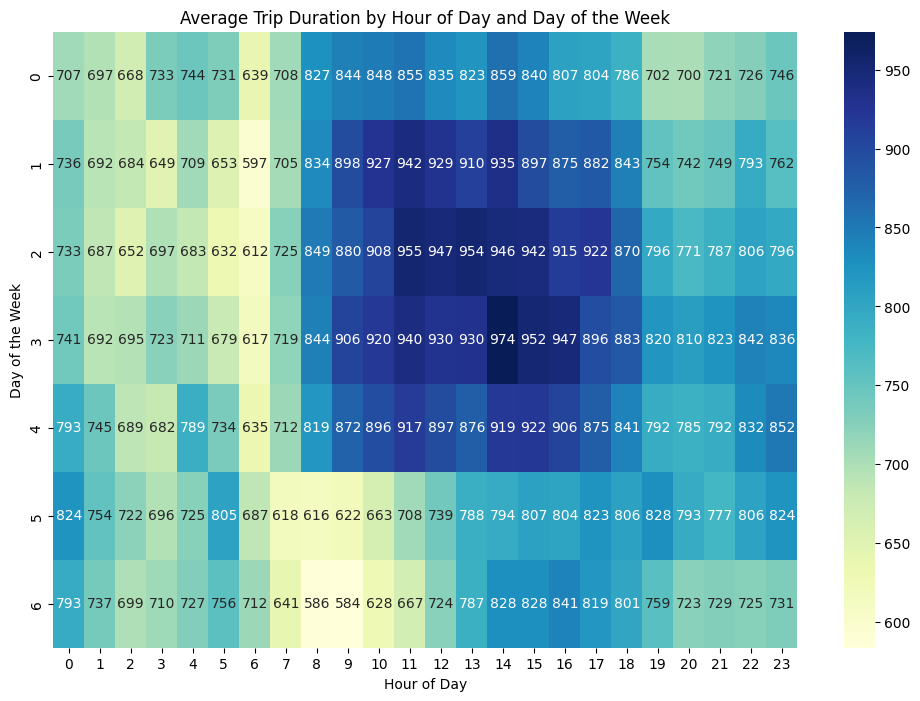

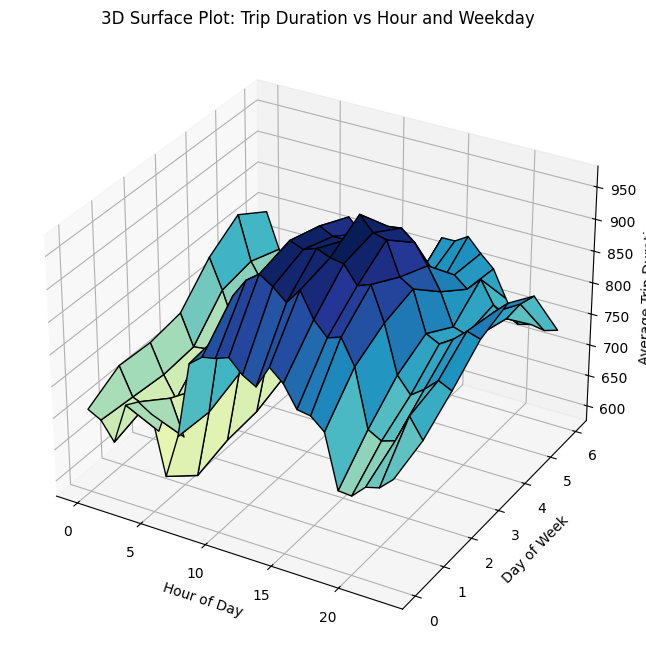

In [28]:
# Heatmap of trip duration across the hours of the day and days of the week
pivot_data = cleaned_data.pivot_table(values='trip_duration', index='pickup_weekday', columns='pickup_hour', aggfunc='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Average Trip Duration by Hour of Day and Day of the Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of the Week')
plt.show()

# 3D Surface plot for trip duration with pickup hour and pickup weekday
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create grid for surface plot
x = np.arange(0, 24)
y = np.arange(0, 7)
x, y = np.meshgrid(x, y)

# Z data: Average trip duration
z = pivot_data.values

# Surface plot
ax.plot_surface(x, y, z, cmap='YlGnBu', edgecolor='k')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Day of Week')
ax.set_zlabel('Average Trip Duration')
ax.set_title('3D Surface Plot: Trip Duration vs Hour and Weekday')
plt.show()


Explanation of Visualizations:

Heatmap: This heatmap will give a clear visual understanding of how average trip duration changes across different times of the day and days of the week. This will help identify patterns, like peak hours on weekdays versus weekends.

You might see that certain hours (like early morning or late evening) show consistently shorter trip durations, whereas midday or rush hours (on weekdays) show longer trip durations.
Weekend trips might have longer durations during different hours compared to weekdays.

i.e The time of day will interact with the day of the week, affecting the duration (e.g., longer trips on weekends around midday).

3D Surface Plot: This plot will give a three-dimensional view of how trip duration varies in both dimensions (time of day and weekday), helping us explore potential interactions between these factors.

The plot will show that trip durations are higher during certain hours and days, confirming the potential interaction effect. For example, you may see a significant increase in trip duration during certain hours on weekends, compared to weekdays.

In [29]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Performing a two-way ANOVA
model = ols('trip_duration ~ C(pickup_hour) + C(pickup_weekday) + C(pickup_hour):C(pickup_weekday)', data=cleaned_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Interpretation
if anova_table['PR(>F)'][2] < 0.05:
    print("There is a significant interaction effect between time of day and day of the week on trip duration.")
else:
    print("There is no significant interaction effect between time of day and day of the week on trip duration.")


                                        sum_sq        df           F  PR(>F)
C(pickup_hour)                    2.572828e+09      23.0  346.673544     0.0
C(pickup_weekday)                 1.171244e+09       6.0  604.970185     0.0
C(pickup_hour):C(pickup_weekday)  1.664676e+09     138.0   37.384221     0.0
Residual                          2.329258e+11  721864.0         NaN     NaN
There is a significant interaction effect between time of day and day of the week on trip duration.


Conclusion :

The results indicate that both time of day and day of the week independently influence trip duration.

There is a significant interaction effect between the two, meaning the patterns in trip duration by hour differ depending on the day of the week.

Key Insights

Weekday vs. Weekend Behavior:Weekends show longer average trip durations compared to weekdays, likely reflecting leisure travel patterns versus weekday commutes.

Trip Duration and Distance:Distance is the primary driver of trip duration, with a strong linear relationship observed.

Time-of-Day and Day-of-Week Interaction:Trip durations are shortest during weekday mornings (commuting hours) and longer on weekends.
Significant interaction indicates complex dependencies between these temporal factors.